In [132]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [133]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [134]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [135]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [136]:
y.shape

(70000,)

In [137]:
y.dtype

dtype('O')

In [138]:
y = y.astype(np.uint8)

In [139]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [140]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [141]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [142]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [143]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [144]:
sgd_clf.predict([some_digit])

array([False])

In [145]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

# Performance measure

## Measuring Accuracy Using Cross-Validation

In [146]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [147]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [148]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

# KNN Classifier

In [149]:
from sklearn.neighbors import KNeighborsClassifier

# y_train_large = (y_train >= 7)
# y_train_odd = (y_train % 2 == 1)
# y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [150]:
# some_digit = X_test[0]

# knn_clf.predict([some_digit])

In [151]:
# print("Predicted multilabel: ", knn_clf.predict([some_digit]))

In [152]:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [166]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=2)

In [167]:
print("Best parameters found by GridSearchCV: ", grid_search.best_params_)

Best parameters found by GridSearchCV:  {'n_neighbors': 3, 'weights': 'distance'}


In [168]:
best_knn_clf = grid_search.best_estimator_
test_score = best_knn_clf.score(X_test, y_test)

print("Test set accuracy using the best model: ", test_score)

Test set accuracy using the best model:  0.9717


## Confusion matrix

In [169]:
# Checking the type of a single element in y_test to ensure it's an integer label
print(type(y_test[0]))


<class 'numpy.uint8'>


In [170]:
# Ensure that y_test and y_pred_knn are both in multiclass format
y_pred_knn = best_knn_clf.predict(X_test)  # Make predictions

print(type(y_pred_knn[0]))


<class 'numpy.uint8'>


In [171]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))


{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


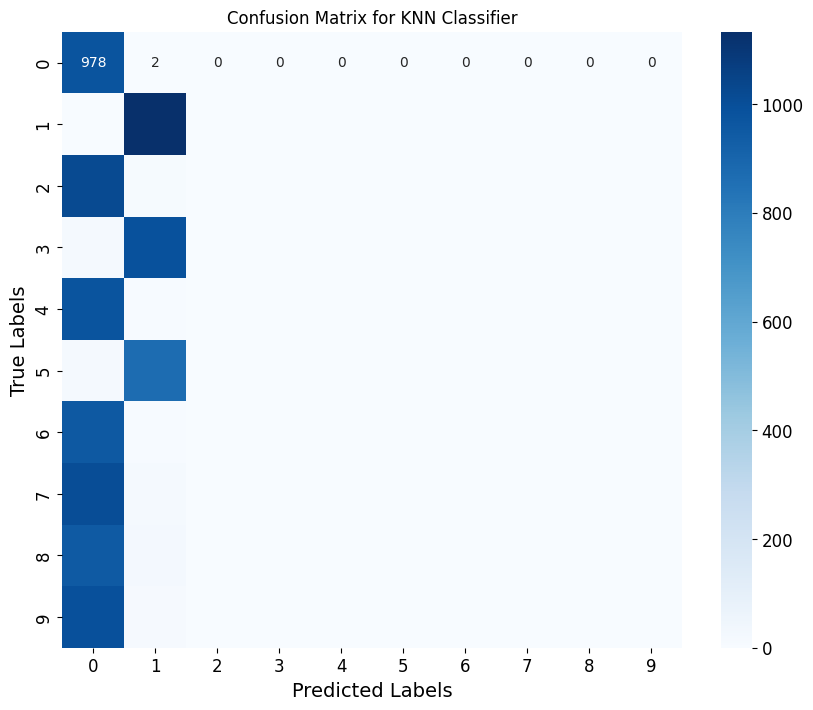

In [172]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix using the converted y_pred_knn
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn_single_class)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for KNN Classifier')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()




## Roc curve

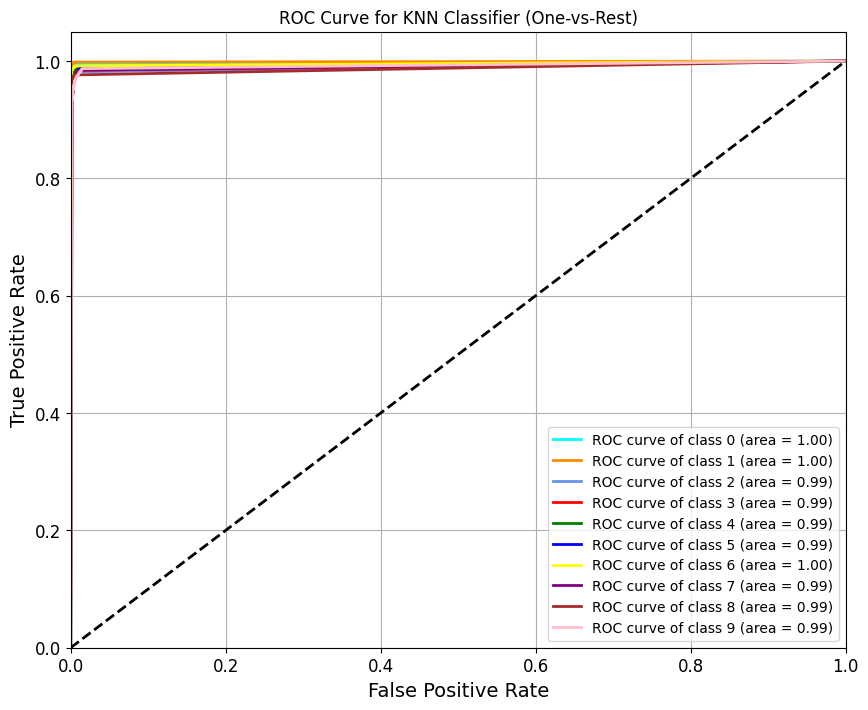

In [173]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Step 1: Binarize the output labels (one-vs-rest for multiclass ROC)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_bin.shape[1]

# Step 2: Fit the KNN classifier
best_knn_clf.fit(X_train, y_train)

# Step 3: Get prediction probabilities
y_score = best_knn_clf.predict_proba(X_test)

# Step 4: Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 5: Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'yellow', 'purple', 'brown', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN Classifier (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Learning Curve

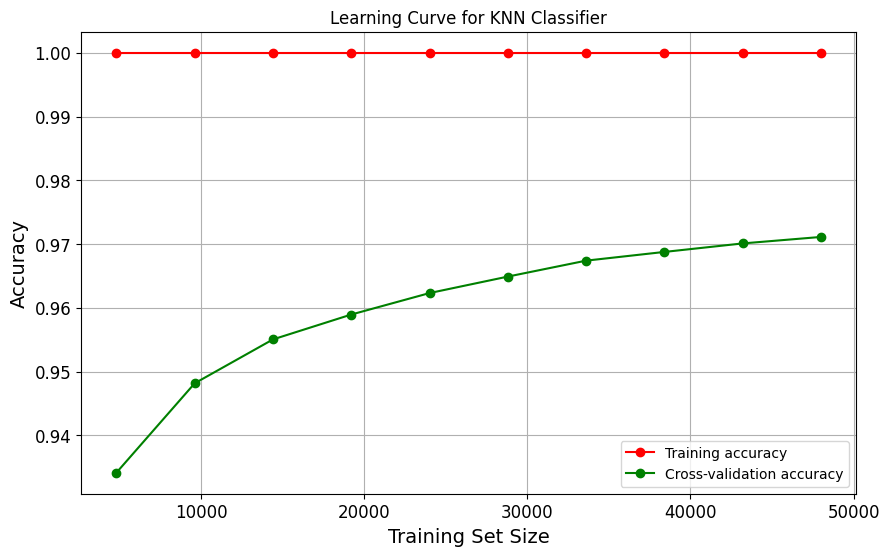

In [174]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(estimator, X, y, title):
    # Generate learning curve data
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
    )
    
    # Calculate mean and standard deviation for training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training accuracy")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation accuracy")
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot the learning curve for the best KNN classifier
plot_learning_curve(best_knn_clf, X_train, y_train, "Learning Curve for KNN Classifier")
